In [204]:
# Imports

import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from scipy.stats import skew

### 1. CO2 Emissions and Climate Change Policies

Total historic emissions have been used to measure the climate responsibility of a country ([BASIC experts, 2011](http://gdrights.org/wp-content/uploads/2011/12/EASD-final.pdf)). The public discussion about blame has moved to the center stage much due to the discussion of the 'Loss and Damage' protocol during COP27. We want to see if high emitting countries has taken measures not just by creating by implementing climate change laws and policies. To do this we have gathered total historic emissions data from [Our World In data](https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions) and analyzing the effects of emissions on rate of which climate change policies have been adopted.

This notebook is used both to investigate a question, but also as a working guide on python, pandas, data cleaning, data exploration, data visualization, statistical modeling, and  regression analysis to gain insight into how to address the concept of causality.



#### 1.1 Research Question

Our Research question breaks down to: 

<p style="text-align:center;"> 💭 Do high polluting countries take responsibility by implementing more climate change policies? 💭</p>



#### 1.2 Literature Research

A vital question regarding climate laws is their effectiveness, does more climate change laws actually reduce emissions? 

We need to address if the quantity of emitted GHG reduce once laws and policies are set in place? After conducting a literature search, we found an article that investigates the effect of such laws and policies, called "[Reduction in greenhouse gas emissions from national climate legislation](https://eprints.lse.ac.uk/105757/1/Eskander_Fankhauser_NCC_Author_Accepted_Manuscript.pdf)" and was written by Shaikh M. S. U. Eskander and Sam Fankhauser. They concluded with "Each new law reduces annual carbon dioxide (CO2) emissions per unit of gross domestic product by 0.78% nationally in the short term (during the first three years) and by 1.79% in the long term (beyond three years)". This study helped us understand why the reverse causality is one of the main issue of our study. With the cross-sectional analysis, we can diminish this bias, however there are a lot of omitted variables that could influence the number of policies and the yearly emissions as well, some of these will be discussed later.

In the article called “[How inequitable is the global distribution of responsibility, capability, and vulnerability to climate change: A comprehensive indicator-based assessment](https://www.sciencedirect.com/science/article/pii/S0959378010000683)”, Hans-Martin Füssel, the author, investigates the relation between responsibility and vulnerability. His article has brought a robust assessment of the implications of climate change on international inequity. He explored the different correlations between vulnerability, capabilities and responsibility. The analysis finds a double inequity between countries’ responsibility/capability and vulnerability for food security, human health, and coastal populations. This article suggests that countries more responsible and often more capable should support vulnerable countries through financial and technical aid. Our article relates to Füssel's article as we investigate if countries that have emitted a lot are implementing new climate laws and policies. 

### 2. Exploratory data analysis on aggregated data

We will begin by doing a cross-sectional analysis of total historic emissions until 2010 versus total number of climate change laws passed after 2012. The reasoning behind the two year gap is that laws implemented after 2012 does not effect the emissions before 2010, thus removing the issue of reverse causality. In general, the visualization and analysis of the aggregated data will be a preliminary analysis to gain insight and help us develop a more robust statistical  approach to our data.

#### 2.1 Extracting the CO2 emission and QOG data

Under is a table of the different variables we collect and calculate, we have renamed some of them to be more explicit. 

| Explanation | QOG variable name | Our variable name |
| --- | ----------- | ----------- |
| Total Climate Change Laws implemented |ccl_nlp | cc_laws_tot |
| Climate Change Laws implemented per year |ccl_lpp | cc_laws_year |
| Country name |country | - |
| Year |year | - |
| Country Code (iso3) |iso_code | iso3 |
| CO2 emissions / year |co2 | - (tons) |
| Country population |population | - |
| Gross Domestic Product | gdp | - ($) |
| CO2 emissions / year / capita (Calculated by us) | - | co2_per_capita (tons) |
| Gross Domestic Product / capita (Calculated by us) | - | gdp_per_capita ($) |

In [205]:
# Fetching emission data from Our World In Data
# https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions
# https://github.com/owid/co2-data
# Fetching QOG data from Eduardo - thank you!

url_co2 = 'https://nyc3.digitaloceanspaces.com/owid-public/data/co2/owid-co2-data.csv'
url_qog = 'https://raw.githubusercontent.com/edoardochiarotti/class_datascience/main/Notebooks/Assignment/individual_assignment/clean_data_prepared_EDA/df_qog_polity_merged.csv'

df_co2 = pd.read_csv(url_co2)
df_qog=pd.read_csv(url_qog)

In [206]:
# Creating a historic subset with key variables

df_co2_historic = df_co2[['country', 'year', 'iso_code', 'population', 'co2', 'gdp']].copy()
df_co2_historic.rename(columns={'iso_code': 'iso3'}, inplace=True)

In [207]:
# Adding a column with Co2 per capita and converting the scale so we have co2_per_capita and total co2 in tons

df_co2_historic['co2'] = df_co2_historic['co2']*1000000
df_co2_historic['co2_per_capita'] =  df_co2_historic['co2']/df_co2_historic['population']
df_co2_historic['gdp_per_capita'] =  df_co2_historic['gdp']/df_co2_historic['population']

#### 2.2 Data cleaning

United Kingdom is called "United Kingdom of Great Britain and Northern Ireland" in the QOG dataset, and only "United Kingdom" in the dataset from Our World in Data. We recognized that Northern Ireland is not included in Our World in Data, thus assume that Northern Ireland is included in United Kingdom, and therefor to to remove ambiguity, rename United Kingdom of Great Britain and Northern Ireland to United Kingdom.

We had a similar problem with the United States of America, we chose the shorter name: United States.

In [208]:

df_climate = df_qog[['country', 'year','iso3', 'ccl_nlp', 'ccl_lpp']].copy()
df_climate.rename(columns={'ccl_nlp': 'cc_laws_tot', 'ccl_lpp' : 'cc_laws_year'}, inplace=True)

# Renaming United States to match the other dataframe
df_climate.replace({'United States of America': 'United States'}, inplace=True)

# We will also rename  United Kingdom of Great Britain and Northern Ireland to United Kingdom, as is in the Co2 dataset. FYI: UK and Ireland are joined there...
df_climate.replace({'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'}, inplace=True)

#### 2.3 Data merging

In [209]:
# Merging historic Co2 data with the subset of the QOG data

df_historic = pd.merge(left=df_co2_historic, right=df_climate, how='left', validate='1:1')
df_historic

,country,year,iso3,population,co2,gdp,co2_per_capita,gdp_per_capita,cc_laws_tot,cc_laws_year
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
46518,Zimbabwe,2017,ZWE,14751101.0,9596000.0,2.194784e+10,0.650528,1487.877848,6.0,0.0
46519,Zimbabwe,2018,ZWE,15052191.0,11795000.0,2.271535e+10,0.783607,1509.106089,8.0,2.0
46520,Zimbabwe,2019,ZWE,15354606.0,11115000.0,NaN,0.723887,NaN,10.0,2.0
46521,Zimbabwe,2020,ZWE,15669663.0,10608000.0,NaN,0.676977,NaN,12.0,2.0


#### 2.4 A clean(?) subset

To visualize with graphs we need a clean dataset. Therefor we will drop `NaN` values in the columns of `cc_laws_tot` and `cc_laws_year`.

In [210]:
df_historic_clean = df_historic.copy()
df_historic_clean = df_historic_clean.dropna(subset=['cc_laws_tot', 'cc_laws_year'])

#### 2.5 First visualization and further improvements

We can find extreme values by doing some simple graphs. Below we can see that Kuwait had 6 x more per capita emissions in 1991 than any other country. It makes sense to remove Kuwait.

In [211]:
fig = px.scatter(df_historic_clean, y="co2_per_capita", x="year",
                 size="co2_per_capita", color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="CO2 emission per capita per country",
    xaxis_title="Year",
    yaxis_title="CO2 emission per capita (tons)",
    legend_title="Countries",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

In [212]:
# Dropping outliers
kuwait_index = df_historic_clean[df_historic_clean.country == 'Kuwait'].index
df_historic_clean.drop(index=kuwait_index, inplace=True)
df_historic.drop(index=kuwait_index, inplace=True)

In [213]:
fig = px.scatter(df_historic_clean, y="cc_laws_year", x="year",
                 color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="Climate change laws per year",
    xaxis_title="Year",
    yaxis_title="Number of CC Laws",
    legend_title="Countries",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

In [214]:
fig = px.scatter(df_historic_clean, y="cc_laws_tot", x="year",
                 color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="Accumulated Climate change laws",
    xaxis_title="Year",
    yaxis_title="Number of Laws",
    legend_title="Countries",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

#### 2.6 First impressions
Our data seems to be complete and as clean as ween need it for now. These visualizations are not the only tools we have used for cleaning, but works fine to give a visual impression. To develop further intuition we will now move to create cross-sectional data.


### 3 Aggregated data
We will now aggregate our data set and for each country end up with one value. Let's see if we can find some correlations and gain further understanding. After the cross-sectional analysis, we will move back to the panel data and perform a more vigorous within-country analysis.

So, our new dataset will look something like this:

| Explanation | Variable name |
| --- | ----------- |
| Total CO2 emissions per country up until 2010 |tot_co2_per_capita_up_till_2010 |
| Total CO2 emissions per country per capita up until 2010 |tot_co2_up_till_2010 |
| Number of climate change laws passed from 2012 -> 2020 |laws_impl_2012_2020 |
| Country name | country |
| Country Code (iso3) | iso3 |
| Gross Domestic Product / capita (2010) | gdp_per_capita |

#### 3.1 Creating aggreated (cross-sectional) data for each country


In [215]:
# Calculating the accumulative emissions per country (both total and per capita)
df_accumulative_co2_2010 = df_historic.copy()
df_accumulative_co2_2010_final = df_accumulative_co2_2010[df_accumulative_co2_2010.year <= 2010]

# Summing up co2 per capita and total co2
df_accumulative_co2_2010_final = df_accumulative_co2_2010.groupby(['iso3', 'country'])['co2_per_capita'].sum().reset_index(name='tot_co2_per_capita_up_till_2010')
df_accumulative_co2_2010_final['tot_co2_up_till_2010'] = df_accumulative_co2_2010.groupby(['iso3', 'country'])['co2'].sum().reset_index(name='tot_co2_up_till_2010').tot_co2_up_till_2010

# Getting the GDP for 2010 for each country, using the word 'temp' to describe the temporary aspects of the df
df_2010_temp = df_accumulative_co2_2010[(df_accumulative_co2_2010.year == 2010) & (df_accumulative_co2_2010.iso3.isin(df_accumulative_co2_2010_final.iso3))]

# Recognizing that not all countries has gdp values
df_2010_temp = df_2010_temp[['country', 'iso3', 'gdp_per_capita']]

df_accumulative_co2_2010_final = pd.merge(left=df_accumulative_co2_2010_final, right=df_2010_temp, how='left', validate='1:1')
# Now we have a datasets with the accumulated co2 emissions per total and per capita, including the gdp for all - 65 countries. 

Now, let's move on to the climate section of the data and collect the total number of climate change polices implemented in each country, and then merge these numbers with `df_accumulative_co2_2010_final` to a dataset we call `df_acc_final` 

In [216]:
df_between_2012_2020 = df_historic_clean.copy()
df_between_2012_2020 = df_between_2012_2020[df_between_2012_2020.year >= 2012]

# Calculating the sum of new climate change policies from 2012 to 2020
df_laws_between_2012_2020 = df_between_2012_2020.groupby(['iso3', 'country'])['cc_laws_year'].sum().reset_index(name='laws_impl_2012_2020')

In [217]:
df_accumulative_final = pd.merge(left=df_accumulative_co2_2010_final, right=df_laws_between_2012_2020, how='left', validate='1:1')
df_accumulative_final = df_accumulative_final.dropna(subset=['laws_impl_2012_2020'])
df_acc_final = df_accumulative_final
df_acc_final.describe()

,tot_co2_per_capita_up_till_2010,tot_co2_up_till_2010,gdp_per_capita,laws_impl_2012_2020
count,171.000000,1.710000e+02,145.000000,171.000000
mean,338.010835,9.436589e+09,17061.870208,6.362573
std,484.783970,3.986477e+10,18509.033271,5.662841
min,2.079042,2.830000e+05,718.664204,0.000000
25%,37.057260,7.986050e+07,3841.269888,2.000000
50%,142.767591,6.424740e+08,10975.979373,4.000000
75%,462.247840,3.704445e+09,23519.704574,8.500000
max,3276.290240,4.219069e+11,136794.321725,33.000000


#### 3.2 Exploratory visualization
Now we can visualize total emissions and by capita up until 2010, and display the number of new policies implemented between 2012 and 2020. Our data is highly skewed so to showcase the differences we will use a logarithmic scale for CO2 emission per capita.

##### 3.2.1 Total Co2 Emissions per capita by country (Until 2010 in Log10 scale)

In [218]:
# Logarithmic scale

df = df_acc_final

fig = go.Figure(data=go.Choropleth(
    locations = df['iso3'],
    z = np.log10(df['tot_co2_per_capita_up_till_2010'].round(0)),
    text = df['country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'CO2 per inhabitant<br>Log10 Scale',
))

fig.update_layout(
    title_text='Total Co2 Emissions per capita by country (Until 2010 in Log10 scale)',
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = [dict(
        x=0.5,
        y=0,    #Trying a negative number makes the caption disappear - I'd like the caption to be below the map
        xref='paper',
        yref='paper',
        text='Source: <a href="https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions">\
            OECD</a>',
        showarrow = False
    )]
)

fig.show()

##### 3.2.3 CO2 Distribution

In [219]:
df = df_acc_final
df_sorted = df.sort_values('tot_co2_up_till_2010', ascending=False)
df_sorted['%'] = (df_sorted['tot_co2_up_till_2010']/df_sorted['tot_co2_up_till_2010'].sum())*100

fig = px.sunburst(df_sorted, path=['country'], values='%', title="CO2 Distribution (% of total)",
                  color='country', hover_data=['%','tot_co2_up_till_2010'])
fig.show()


##### 3.2.4 Climate change laws (2012-2020)

In [220]:
df = df_acc_final

fig = go.Figure(data=go.Choropleth(
    locations = df['iso3'],
    z = df['laws_impl_2012_2020'].round(0),
    text = df['country'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'Number of laws',
))

fig.update_layout(
    title_text='Number of climate change laws implemented from 2012-2020',
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = [dict(
        x=0.5,
        y=0,    #Trying a negative number makes the caption disappear - I'd like the caption to be below the map
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.gu.se/en/quality-government/qog-data/data-downloads/environmental-indicators-dataset">\
            QOG</a>',
        showarrow = False
    )]
)

fig.show()

By conducting the exploratory analysis we have learned that the US stands for more than 25% of the global CO2 emissions per capita. Another interesting observation is that the countries with most climate change laws implemented (2012-2020) seems to have a shore, meaning that it would be affected by sea level rise. In addition it seems that a lot of western Europe has implemented many climate change laws. Now we will try to figure out wether the high emitting countries do take climate action by implementing climate change polices.

#### 3.3 Scatterplots and OLS

The following code displays a scatterplot of CO2 per capita ut till 2010 on climate change laws implemented between 2012 and 2020. The red line represents the ordinary least squared (OLS). Below the graph is a regression table, we will decipher its meaning and discuss its limitations and insignificance. 

In [221]:
df = df_acc_final

fig = px.scatter(df, y="laws_impl_2012_2020", x="tot_co2_per_capita_up_till_2010",
                 hover_name="country", trendline='ols', hover_data={'laws_impl_2012_2020': ':.1f', 'tot_co2_per_capita_up_till_2010': ':.1f'},
                 trendline_color_override='red',
                 labels={'laws_impl_2012_2020': 'Climate change laws implemented 2012-2020',
                         'tot_co2_per_capita_up_till_2010': 'Tot Co2 emissions<br> per capita until 2010'},
                 log_x=False)

fig.update_layout(
    title="Historic Per Capita Emissions (->2010) vs Climate Change Polices (2012->2020) - with OLS trendline",
    xaxis_title="CO2 Emissions (tons)",
    yaxis_title="Climate Change Policies",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

results = px.get_trendline_results(fig)
fig.show()
print(results.px_fit_results.iloc[0].summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7640
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.383
Time:                        19:40:11   Log-Likelihood:                -538.25
No. Observations:                 171   AIC:                             1081.
Df Residuals:                     169   BIC:                             1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0977      0.529     11.531      0.0

#### 3.4 Reflections on preliminary analysis

- T-Value: 0.874 - indicating that it's not significant at all.
- R-Squared: Ranges from `0-1`, with a higher value indicating a better fit. In our case, the R-squared value is `0.005`, which suggests that the model does not fit the data well.
- H0 : x1 = 0, H1 : x1 != 0
- Prob (P-value): The p-value is `0.383`, meaning a 38% probability that x1 is equal `0`. This tells us that we cannot reject the `H0` with a `95%` certainty.

We could have anticipated that our statistical model would not be very robust. There are several cases that we need to address. First of all - there are several omitted variables present that can drive climate change policies. As of now - climate polices can dampen the economic prosperity of a country - thus, requiring a country to have a solid GDP to afford to incorporate climate change laws. To illustrate how GDP is linked to CO2, we can include a simple emission driver illustration created by Our World In Data. So, we certainly need to find a way around this intricate relationship. To showcase this relationship we will do a scatterplot using GDP per capita as a predictor for CO2 emissions, and then GDP per capita as a predictor for new climate change policies implemented between 2012-2020. Our guess is that there is a positive coefficient to be found.

<img src='https://ourworldindata.org/uploads/2020/07/Kaya-identity.png' width="600" height="300" />

As stated: GDP and CO2 emissions' relationship is complicated. And we can draw directed graph to show how this relationship can complicate our analysis.

##### 3.4.1 GDP as omitted variable

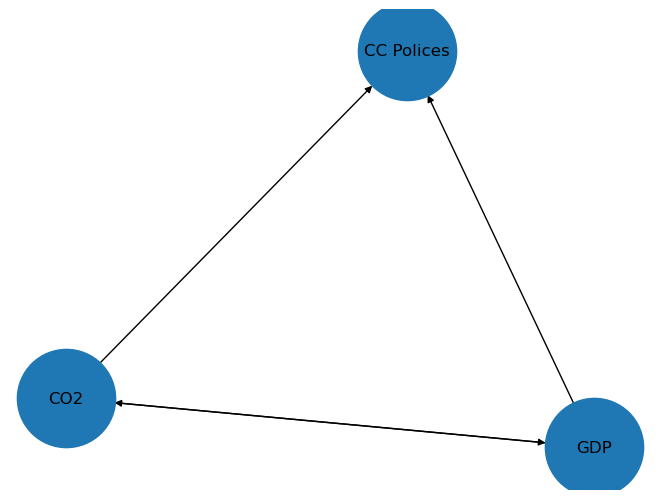

In [222]:
# Create a directed graph
G = nx.DiGraph()

# Adding the nodes to our graph
G.add_edge('GDP', 'CO2', color='red')
G.add_edge('CO2', 'GDP', color='blue')
G.add_edge('GDP', 'CC Polices')
G.add_edge('CO2', 'CC Polices')

nx.draw(G, with_labels=True, node_size=5000)


#### 3.4.2 GDP (per capita) vs CO2 (per capita)


In [223]:
df = df_acc_final.dropna(subset=['gdp_per_capita']).copy()

fig = px.scatter(df, x="gdp_per_capita", y="tot_co2_per_capita_up_till_2010",
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'gdp_per_capita': 'GDP / Capita (2010) ',
                         'tot_co2_per_capita_up_till_2010': 'CO2 / Capita '},
                 log_x=False)

fig.update_layout(
    title="GDP in 2010 vs Historic per capita CO2 emissions<br>With OLS trendline",
    xaxis_title="GDP per capita ($)",
    yaxis_title="CO2 per capita (tons)",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

results = px.get_trendline_results(fig)
fig.show()
print(results.px_fit_results.iloc[0].summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     284.7
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           7.72e-36
Time:                        19:40:11   Log-Likelihood:                -1030.6
No. Observations:                 145   AIC:                             2065.
Df Residuals:                     143   BIC:                             2071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.5761     33.656     -0.433      0.6

In [224]:
df = df_acc_final.dropna(subset=['gdp_per_capita']).copy()

fig = px.scatter(df, x="gdp_per_capita", y="laws_impl_2012_2020",
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'gdp_per_capita': 'GDP / Capita (2010) ',
                         'cc_laws_year': 'CC laws implemented'},
                 log_x=False)

fig.update_layout(
    title="GDP (per capita) 2010 vs Climate Change laws (2012-2020)<br>With OLS trendline",
    xaxis_title="GDP per capita ($)",
    yaxis_title="# CC laws implemented (2012-2020)",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

results = px.get_trendline_results(fig)
fig.show()


In [225]:
df = df_acc_final.dropna(subset=['gdp_per_capita', 'tot_co2_per_capita_up_till_2010']).copy()

fig = px.scatter(df, x="tot_co2_per_capita_up_till_2010", y="laws_impl_2012_2020", size='gdp_per_capita',
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'tot_co2_per_capita_up_till_2010': 'CO2 / Capita (->2010) ', 
                         'laws_impl_2012_2020': 'Climate Change Laws (2012-2020) '},
                 log_x=False)

fig.update_layout(
    title="CO2 emissions vs Climate Change Polices (2012->2020)<br>Circle size depending on GDP/capita. With OLS trendline",
    xaxis_title="CO2 per capita (tons)",
    yaxis_title="Climate Change Policies",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

results = px.get_trendline_results(fig)
fig.show()

#### 3.4.3 Conclusion for cross-sectional data

What see  in the graphs above and regression tables is that GDP is tightly coupled and a significant predictor for CO2 emissions. We also recognize that GDP has a higher positive coefficient for climate change laws than CO2 emissions. If we removed the effects of GDP from the plot between CO2 and climate change laws, would the graph then change?...

So, to summarize: GDP is just ONE example of omitted variables, there are many more, such as:
1.  Government: Countries with stricter environmental regulations may have lower levels of CO2 emissions and stricter climate change laws.
2.  Geography & Climate: Countries with very warmer climates higher levels of CO2 emissions and less strict climate change laws, and at the same time countries with very cold climates may also have higher  levels of CO2 emissions and less stricter climate change laws. Due to either e.g. domestic cooling or warming systems.
3. Energy-mix: Countries with a higher mix of fossil fuels may have higher levels of CO2 emissions and less strict climate change laws, while countries with a higher mix of renewable energy sources may have lower levels of CO2 emissions and stricter climate change laws. 

So, let's try to do some within-country analysis to escape this intricate web of biases.

### 4. Panel data - within-country analysis

#### 4.1 Multivariate clustered analysis

First, we can try to use clustered standard errors,  a method of adjusting the standard errors of the estimates in a linear regression model to account for the fact that the observations within each group  are correlated.

The idea behind clustered standard errors is that the errors within each cluster are more likely to be correlated than the errors between different clusters. By doing this we can improve our predictions, since the method takes into account similarity within-country.

To calculate clustered standard errors, we will use `country`. Standard errors of the estimates will then take into account the within-cluster correlations.

In addition can we add GDP as a predictor, making it a multivariate analysis.

However, using clustered standard errors can also lead to larger standard errors, as the adjustment for the within-cluster correlations increases the variability of the estimates.

We will now move back to the historic panel data, where each country has several observations.

In [226]:
# load historic data and remove NaNs
df = df_historic.dropna(subset=['co2_per_capita', 'cc_laws_year', 'gdp_per_capita']).copy()

# setting more explicit variable names to the regression result
features = ['CO2 per capita', 'GDP per capita']


X = np.array(df[['co2_per_capita', 'gdp_per_capita']])  # predictor variables
y = np.array(df['cc_laws_year'])  # dependent variable

# estimate the parameters of the model using clustering
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df['country']})

print(results.summary(xname=features))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.147
Model:                            OLS   Adj. R-squared (uncentered):              0.147
Method:                 Least Squares   F-statistic:                              18.27
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                    8.47e-08
Time:                        19:40:11   Log-Likelihood:                         -4035.3
No. Observations:                2875   AIC:                                      8075.
Df Residuals:                    2873   BIC:                                      8086.
Df Model:                           2                                                  
Covariance Type:              cluster                                                  
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

Short summary and interpretation of the clustered regression table above.

* The model explains about 5.4% of the variance in Climate Change Laws.
* The F-statistic is 5.595, which suggests that at least one of the coefficients in the model is non-zero. 
* The p-value of the F-statistic is 0.0191, which indicates that the model is statistically significant.
* The independent variable (CO2 per capita) has a coefficient estimate of 0.0249, which means that for each unit increase in CO2/capita, Climate Change laws is expected to increase by 0.0249 units.
* The standard error of the coefficient estimate is 0.011, which is a measure of the uncertainty around the estimate. 
* The p-value of the coefficient estimate is 0.018, which indicates that the coefficient is statistically significant. 
* The 95% confidence interval of the coefficient estimate is [0.004, 0.046], which means that there is a 95% chance that the true value of the coefficient falls within this interval.

So, can we with significance say that polluting more per capita translates to incorporating fewer climate change policies? We are not confident enough in this analysis so we will try to approach our research question from another angle. 

#### 4.2 What if?...

What if we where to look at how much a country emits can effect climate laws implemented two years later? The laws two years later will certainly not effect historic emissions, thus removing reverse causality. We can also argue that it takes some time to calculate the emissions, and additionally to actually implement polices. We can use two tables to explain what we will do:


| Year | Country | ISO3 | CO2 per capita | Climate Change Laws Implemented |
| --- | ----------- | ----------- | ----------- | ----------- |
| 2000 | Norway | NOR | 5.0 | 1 |
| 2001 | Norway | NOR | 5.1 | 0 |
| 2002 | Norway | NOR | 4.9 | 1 |
| 2003 | Norway | NOR | 5.2 | 2 |
| 2004 | Norway | NOR | 5.5 | 0 |

So if we shift the CO2 per capita up two we will get the following data structure:
| Year | Country | ISO3 | CO2 per capita (t-2)| Climate Change Laws Implemented |
| --- | ----------- | ----------- | ----------- | ----------- |
| 2000 | Norway | NOR | 4.9 | 1 |
| 2001 | Norway | NOR | 5.2 | 0 |
| 2002 | Norway | NOR | 5.5 | 1 |
| 2003 | Norway | NOR | - | 2 |
| 2004 | Norway | NOR | - | 0 |

We have now found a new method to calculate the relationship between emission change and climate change laws. This way we can internalize a lot of country differences, so let's try to do this on the large dataset.

In [246]:
# Work in progress
df_historic_wip = df_historic.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year'])
num_years_to_shift = 2

# shifting the co2_per_capita column by -2
df_historic_wip['co2_per_capita'] = df_historic_wip.co2_per_capita.shift(-num_years_to_shift)
df_historic_wip = df_historic_wip[:-num_years_to_shift]

df = df_historic_wip.copy()

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", trendline='ols', trendline_color_override='red', trendline_options=dict(log_x=False),
                 hover_name="country",
                 size="co2_per_capita",
                 log_x=False,
                 labels={'cc_laws_year': '#CC laws',
                         'co2_per_capita': 'CO2 year / Capita'},
                 )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies <br> Global",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.show()

#### A short reflection on the panel data outcome. 

We can see that there is as small negative correlation between CO2 per capita and Climate change laws implemented two years after. The reasoning behind two years is that first of all, emissions data are complicated to calculate, and thereafter we have to expect political lag. So it may be that 2 years is even a little optimistic. But let's see how changing the `num_years_to_shift` changes the graph. After investigating the difference when we chose  `1,2,3,4,[...]` year lag it's seems to be pretty much the same. 

To gain further understanding, we could devide the timeframe into three:
1. Pre Kyoto Procotol (< 1997), 
2. Pre Paris Agreement (1998 - 2015)
3. Post Paris Agreement (> 2016)

But there can still be other variances such as political change in these periods, for instance, Donald Trump was elected president in 2016, and cut down on Climate Change laws.

In [229]:
# Work in progress
df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])
num_years_to_shift = 2

df_historic_wip['co2_per_capita'] = df_historic_wip.co2_per_capita.shift(-num_years_to_shift)
df_historic_wip = df_historic_wip[:-num_years_to_shift]


# Creating a new column stating with a marker for pre_kyo, pre_par and post_par
df = df_historic_wip.copy()

conditions = [
    df['year'] < 1997,
    ((df['year'] >= 1997 ) & (df['year'] <= 2016)),
    df['year'] > 2016,
]

choices = ['pre_kyo', 'pre_par', 'post_par']

df['protocol'] = np.select(conditions, choices)

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                size="co2_per_capita",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies <br> Global",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.show()

This is interesting, it seems that the paris agreement has really put pressure on the countries to take action. We could divide into countries that has an higher than avg gdp and lower than avg gdp, but since we have so few datas for gdp after 2016, we will focus  on really high emitting countries. Hence divide into two groups: 
1. Above mean `co2_per_capita`
2. Below mean `co2_per_capita`

In [230]:
# Work in progress
import math

df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(
    subset=['cc_laws_year', 'co2_per_capita'])
num_years_to_shift = 2

df_historic_wip['co2_per_capita'] = df_historic_wip.co2_per_capita.shift(
    -num_years_to_shift)
df_historic_wip = df_historic_wip[:-num_years_to_shift]


# Creating a new column  with a marker for pre_kyo, pre_par and post_par
# Creating a new column
df = df_historic_wip.copy()
mean_gdp = df.co2_per_capita.mean()

conditions = [
    df['year'] < 1997,
    ((df['year'] >= 1997) & (df['year'] <= 2016)),
    df['year'] > 2016,
]

condition_co2 = [
    df['co2_per_capita'] < mean_gdp,
    (df['co2_per_capita'] >= mean_gdp) | (
        np.isclose(df['co2_per_capita'], mean_gdp))
]

choices = ['pre_kyo', 'pre_par', 'post_par']
choices_co2 = ['below_mean', 'above_mean']

df['protocol'] = np.select(conditions, choices)
df['co2_rel'] = np.select(condition_co2, choices_co2)

#df = df.dropna(subset=['gdp_rel'])
#df = df[df.gdp_rel != '0'].copy()

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_row='co2_rel', facet_col='protocol', trendline='ols', trendline_color_override='red',
                 category_orders={"protocol": [
                     "pre_kyo", "pre_par", "post_par"]},
                 hover_name="country",
                 size="co2_per_capita",
                 log_x=False,
                 labels={'cc_laws_year': '#CC laws',
                         'co2_per_capita': 'CO2 year / Capita'},
                 )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies (Global)",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

results = px.get_trendline_results(fig)
fig.show()


In [231]:

# Work in progress
import math

df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])
num_years_to_shift = 2

df_historic_wip['co2_per_capita'] = df_historic_wip.co2_per_capita.shift(-num_years_to_shift)
df_historic_wip = df_historic_wip[:-num_years_to_shift]


# Creating a new column  with a marker for pre_kyo, pre_par and post_par
# Creating a new column 
df = df_historic_wip.copy()
mean_gdp = df.co2_per_capita.mean()

conditions = [
    df['year'] < 1997,
    ((df['year'] >= 1997 ) & (df['year'] <= 2016)),
    df['year'] > 2016,
]

condition_co2 = [
    df['co2_per_capita'] < mean_gdp,
    (df['co2_per_capita'] >= mean_gdp) | (np.isclose(df['co2_per_capita'], mean_gdp))
]

choices = ['pre_kyo', 'pre_par', 'post_par']
choices_co2 = ['below_mean', 'above_mean']

df['protocol'] = np.select(conditions, choices)
df['co2_rel'] = np.select(condition_co2, choices_co2)

df = df[df.co2_rel == 'below_mean']

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                size="co2_per_capita",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies (Global) <br> Countries below mean CO2/Capita)",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.show()


In [232]:

# Work in progress
import math

df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])

kuwait_index = df_historic_wip[df_historic_wip.country == 'Kuwait'].index
df_historic_wip.drop(index=kuwait_index, inplace=True)

num_years_to_shift = 2

df_historic_wip['co2_per_capita'] = df_historic_wip.co2_per_capita.shift(-num_years_to_shift)
df_historic_wip = df_historic_wip[:-num_years_to_shift]


# Creating a new column  with a marker for pre_kyo, pre_par and post_par
# Creating a new column 
df = df_historic_wip.copy()
mean_gdp = df.co2_per_capita.mean()
conditions = [
    df['year'] < 1997,
    ((df['year'] >= 1997 ) & (df['year'] <= 2016)),
    df['year'] > 2016,
]

condition_co2 = [
    df['co2_per_capita'] < mean_gdp,
    (df['co2_per_capita'] >= mean_gdp) | (np.isclose(df['co2_per_capita'], mean_gdp))
]

choices = ['pre_kyo', 'pre_par', 'post_par']
choices_co2 = ['below_mean', 'above_mean']

df['protocol'] = np.select(conditions, choices)
df['co2_rel'] = np.select(condition_co2, choices_co2)

df = df[df.co2_rel == 'above_mean']

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                size="co2_per_capita",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies (Global) <br> Countries above mean CO2/Capita)",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.show()


As we see, only the countries that emit more than the average co2 emissions per capita react to the paris agreement.
We want to do a diff in diff analysis between two similar countries, one who has joined the paris agreement in 2016 and one that hasn't. 
We chose Turkey and Bulgaria because they are neighbours and because the have almost the same emissions per capita in 2016 (6.277 for Bulgaria vs 5.003 for Turkey in tons per capita and per year), so the idea is that they should react the same to the paris agreement.  

In [233]:
df_turkey_bulgaria = df_historic[(df_historic.country == 'Turkey') | (df_historic.country == 'Bulgaria')] 
df_turkey_bulgaria = df_turkey_bulgaria[df_turkey_bulgaria.year >= 2012]
df_turkey_bulgaria = df_turkey_bulgaria.dropna(subset=['cc_laws_year'])

df = df_turkey_bulgaria
fig = px.scatter(df, x="year", y="cc_laws_year",
                hover_name="country",
                trendline='ols',
                color='country',
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Bulgaria and Turkey Diff in Diff",
    
    xaxis_title="Year",
    yaxis_title="CC Laws per year",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.add_vline(x=2016)
fig.show()


In [234]:
# Co2 Emissions

df_turkey_bulgaria = df_historic[(df_historic.country == 'Turkey') | (df_historic.country == 'Bulgaria')] 
df_turkey_bulgaria = df_turkey_bulgaria[df_turkey_bulgaria.year >= 2012]
df_turkey_bulgaria = df_turkey_bulgaria.dropna(subset=['co2_per_capita'])


condition_treatment = [
    df_turkey_bulgaria['year'] <= 2016,
    df_turkey_bulgaria['year'] > 2016,
]

choices = ['pre_paris', 'post_paris']

df_turkey_bulgaria['treatment'] = np.select(condition_treatment, choices)

df = df_turkey_bulgaria
fig = px.scatter(df, x="year", y="co2_per_capita",
                hover_name="country",
                trendline='ols',
                facet_col='treatment',
                color='country',
                log_x=False,
                labels={'year': 'Year',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Bulgaria and Turkey Diff in Diff",
    
    xaxis_title="Year",
    yaxis_title="CO2 per capita",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.add_vline(x=2016)
fig.show()


In [235]:
# Co2 Emissions

df_turkey_bulgaria = df_historic[(df_historic.country == 'Turkey') | (df_historic.country == 'Bulgaria')] 
df_turkey_bulgaria = df_turkey_bulgaria[df_turkey_bulgaria.year >= 2010]
df_turkey_bulgaria = df_turkey_bulgaria.dropna(subset=['cc_laws_year'])


condition_treatment = [
    df_turkey_bulgaria['year'] <= 2016,
    df_turkey_bulgaria['year'] > 2016,
]

choices = ['pre_paris', 'post_paris']

df_turkey_bulgaria['treatment'] = np.select(condition_treatment, choices)

df = df_turkey_bulgaria
fig = px.scatter(df, x="year", y="cc_laws_year",
                hover_name="country",
                trendline='ols',
                facet_col='treatment',
                color='country',
                log_x=False,
                labels={'year': 'Year',
                        'cc_laws_year': 'CLimate Change Laws or Polices'},
                )
fig.update_layout(
    title=f"Bulgaria and Turkey Diff in Diff : CC Laws or Policies",
    
    xaxis_title="Year",
    yaxis_title="CC Laws or Policies",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.add_vline(x=2016)
fig.show()


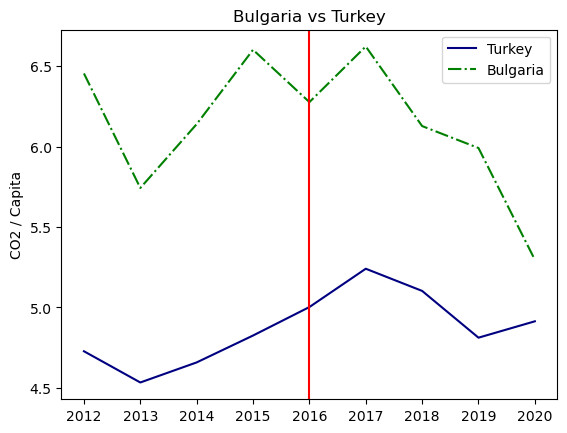

In [236]:
df_turkey_bulgaria = df_turkey_bulgaria[(df_turkey_bulgaria.year >= 2012) & (df_turkey_bulgaria.year <= 2020)]
df = df_turkey_bulgaria
plt.plot(df[(df['country'] == 'Turkey')]['year'],
         df[(df['country'] == 'Turkey')]['co2_per_capita'],
         color = "navy", linestyle = '-', label = "Turkey")

plt.plot(df[(df['country'] == 'Bulgaria')]['year'],
         df[(df['country'] == 'Bulgaria')]['co2_per_capita'],
         color = "green", linestyle = '-.', label = "Bulgaria")


plt.title("Bulgaria vs Turkey")
plt.xlabel("")
plt.ylabel("CO2 / Capita")
plt.axvline(x=2016, ymin=0, ymax=100, color='red')
plt.legend()

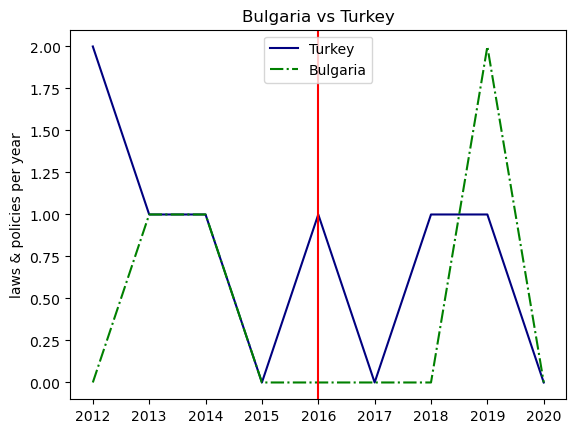

In [237]:
df_turkey_bulgaria = df_turkey_bulgaria[(df_turkey_bulgaria.year >= 2012) & (df_turkey_bulgaria.year <= 2020)]
df = df_turkey_bulgaria
plt.plot(df[(df['country'] == 'Turkey')]['year'],
         df[(df['country'] == 'Turkey')]['cc_laws_year'],
         color = "navy", linestyle = '-', label = "Turkey")

plt.plot(df[(df['country'] == 'Bulgaria')]['year'],
         df[(df['country'] == 'Bulgaria')]['cc_laws_year'],
         color = "green", linestyle = '-.', label = "Bulgaria")


plt.title("Bulgaria vs Turkey")
plt.xlabel("")
plt.ylabel("laws & policies per year")
plt.axvline(x=2016, ymin=0, ymax=100, color='red')
plt.legend()

In [238]:
# Co2 Emissions


df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])

kuwait_index = df_historic_wip[df_historic_wip.country == 'Kuwait'].index
df_historic_wip.drop(index=kuwait_index, inplace=True)

# Creating a new column  with a marker for pre_kyo, pre_par and post_par
# Creating a new column 
df = df_historic_wip.copy()
mean_gdp = df.co2_per_capita.mean()

conditions = [
    df['year'] < 1997,
    ((df['year'] >= 1997 ) & (df['year'] <= 2016)),
    df['year'] > 2016,
]

condition_co2 = [
    df['co2_per_capita'] < mean_gdp,
    (df['co2_per_capita'] >= mean_gdp) | (np.isclose(df['co2_per_capita'], mean_gdp))
]

choices = ['pre_kyo', 'pre_par', 'post_par']
choices_co2 = ['below_mean', 'above_mean']

df['protocol'] = np.select(conditions, choices)
df['co2_rel'] = np.select(condition_co2, choices_co2)

df = df_turkey_bulgaria
fig = px.scatter(df, x="year", y="cc_laws_year",
                hover_name="country",
                trendline='ols',
                facet_col='treatment',
                color='country',
                log_x=False,
                labels={'year': 'Year',
                        'cc_laws_year': 'CLimate Change Laws or Polices'},
                )
fig.update_layout(
    title=f"Bulgaria and Turkey Diff in Diff : CC Laws or Policies",
    
    xaxis_title="Year",
    yaxis_title="CC Laws or Policies",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)
results = px.get_trendline_results(fig)
fig.add_vline(x=2016)
fig.show()

# Add horizontal mean

In [239]:
df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])

kuwait_index = df_historic_wip[df_historic_wip.country == 'Kuwait'].index
df_historic_wip.drop(index=kuwait_index, inplace=True)

df = df_historic_wip.copy()
df = df[df["year"]>2008]

df_year_groupby = df.groupby(['year'])['cc_laws_year'].mean().reset_index(name='mean_cc_laws_year')
df_year_groupby['threshold'] = (df_year_groupby["year"] > 2016)

df_year_groupby.loc[7,"mean_cc_laws_year"]=None



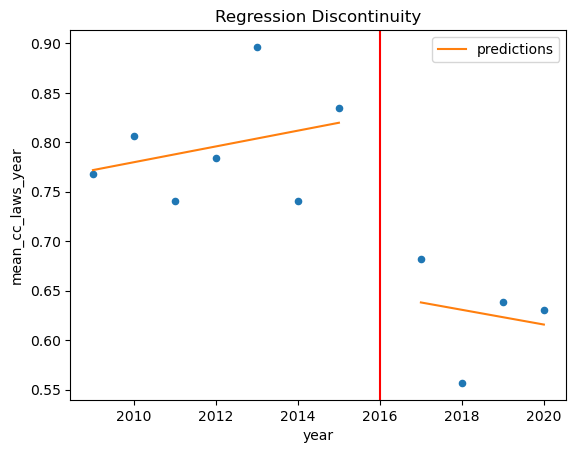

In [240]:

model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby).fit()

ax = df_year_groupby.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.axvline(2016, 0,10, color="red")


We see that on average, after the paris agreement, there are not many more laws and policies that are implemented, there are even less that are implemented every year.

In [241]:
#for more than mean co2_per_capita
df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])

kuwait_index = df_historic_wip[df_historic_wip.country == 'Kuwait'].index
df_historic_wip.drop(index=kuwait_index, inplace=True)

df = df_historic_wip.copy()
df = df[(df["year"]>2008)]
mean_co2_per_capita = df.co2_per_capita.mean()
df= df[(df["co2_per_capita"]>mean_co2_per_capita)]
df_year_groupby = df.groupby(['year'])['cc_laws_year'].mean().reset_index(name='mean_cc_laws_year')
df_year_groupby['threshold'] = (df_year_groupby["year"] > 2016)

df_year_groupby.loc[7,"mean_cc_laws_year"]=None

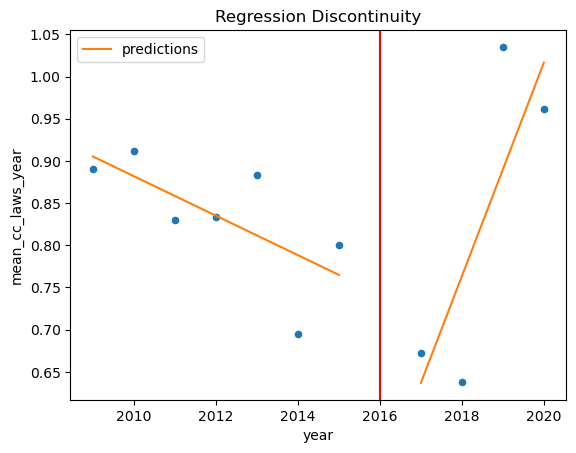

In [242]:
model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby).fit()

ax = df_year_groupby.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.axvline(2016, 0,10, color="red")

If we look at the above mean countries 

In [243]:
#for counties and year with less than the mean co2_per_capita 
df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(subset=['cc_laws_year', 'co2_per_capita'])

kuwait_index = df_historic_wip[df_historic_wip.country == 'Kuwait'].index
df_historic_wip.drop(index=kuwait_index, inplace=True)

df = df_historic_wip.copy()
mean_co2_per_capita = df.co2_per_capita.mean()

df = df[(df["year"]>2008)]
mean_co2_per_capita = df.co2_per_capita.mean()
df= df[(df["co2_per_capita"] < mean_co2_per_capita)]

df_year_groupby = df.groupby(['year'])['cc_laws_year'].mean().reset_index(name='mean_cc_laws_year')
df_year_groupby['threshold'] = (df_year_groupby["year"] > 2016)

df_year_groupby.loc[7,"mean_cc_laws_year"]=None

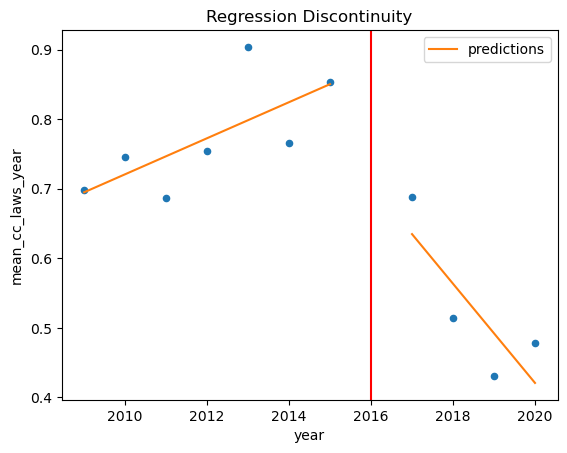

In [244]:
model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby).fit()

ax = df_year_groupby.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.axvline(2016, 0,10, color="red")

#### 99. Appendix